## Analysis of Yelp Product Reviews using Python

You need to create your environment and activate it first.  Use the environment.yml file in the repo and 
```` 
>conda env create -f environment.yml
... agree to all installs...
>source activate esnlp
````


In [1]:
import json
import gensim
import matplotlib.pyplot as plt
import numpy as np
import string
import pandas as pd

In [19]:
import seaborn as sns

In [2]:
import nltk

In [3]:
%matplotlib inline

## Load the data and put into Pandas Dataframe

You will need to gunzip the yelp data first if you load this from the repo.

In [1]:
!gunzip data/yelp_academic_dataset_reviews.json.gz

In [4]:
data = []
with open("data/yelp_academic_dataset_reviews.json") as handle:
    for line in handle.readlines():
        yelp = json.loads(line)
        data.append(yelp)

In [7]:
len(data)

229907

In [38]:
df = pd.DataFrame.from_dict(data)

In [39]:
df.head()

,business_id,date,review_id,stars,text,type,user_id,votes
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,"{u'funny': 0, u'useful': 5, u'cool': 2}"
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,"{u'funny': 0, u'useful': 0, u'cool': 0}"
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,"{u'funny': 0, u'useful': 1, u'cool': 0}"
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,"{u'funny': 0, u'useful': 2, u'cool': 1}"
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,"{u'funny': 0, u'useful': 0, u'cool': 0}"


In [40]:
# I'm deleting votes because it's out of scope for this talk...
del df['votes']
del df['type']

In [41]:
df.head()

,business_id,date,review_id,stars,text,user_id
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,rLtl8ZkDX5vH5nAx9C3q5Q
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,0a2KyEL0d3Yb1V6aivbIuQ
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,0hT2KtfLiobPvh6cDC8JQg
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",uZetl9T0NcROGOyFfughhg
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,vYmM4KTsC8ZfQBg-j5MWkw


In [45]:
# Save to a file for re-use
df.to_msgpack('data/yelp_full_df.msg')

In [46]:
# load from file:
df = pd.read_msgpack('data/yelp_full_df.msg')

## A few quick exploratory plots...

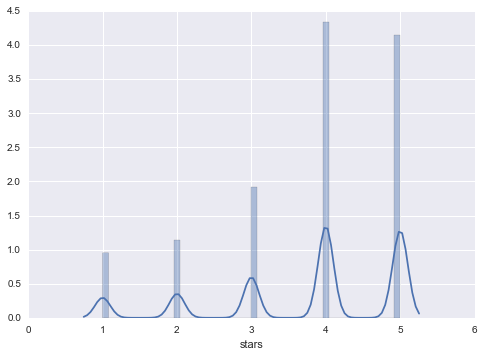

In [8]:
sns.distplot(df.stars)

## Group by Business

In [47]:
biz = df.groupby("business_id")

In [48]:
len(biz)

11537

In [49]:
biz_summary = biz.agg({'date': len, 'stars': [np.median, np.mean, np.std]})

biz_summary.sort_values([('date','len')], ascending=False).head()

date  stars                    
                        len median      mean       std
business_id                                           
hW0Ne_HTHEAgGF1rAdmR-g  844    3.0  3.236967  1.040466
VVeogjZya58oiTxK7qUjAQ  794    4.0  3.964736  1.217264
JokKtdXU7zXHcr20Lrk29A  731    4.0  4.310534  0.794251
ntN85eu27C04nwyPa8IHtw  679    4.0  3.998527  1.109757
EWMwV5V9BxNs_U6nNVMeqw  645    4.0  4.130233  0.948242

In [14]:
biz_summary[biz_summary.date.len == 50]

date  stars                
                        len median  mean       std
business_id                                       
-1bOb2izeJBZjHC7NWxiPA   50    4.0  3.32  1.096190
-O7H5LhBkE13VQZB0QZI0Q   50    3.0  2.92  1.139996
679pJn1KyKr2X8NcQNyMzA   50    4.0  4.08  1.065986
74qDPs2dR6gSzDp6N1U-Og   50    4.0  3.94  1.150155
863nEWkPZ7uD-ZRTmmJokw   50    4.0  3.66  1.318781
8qrICL2tS2Rq7b5gxUdQwQ   50    4.0  3.76  1.270706
BJfjd8oEMW_zq8KTkixyig   50    3.0  3.30  1.092647
G5SASWuL_CVxpgwXXGC4DA   50    4.0  3.46  1.459801
Hw8-13eEQKdtTnUxwUkkHw   50    5.0  4.46  0.734291
K4Oo7A5Kp5eSgBV7MgOu8Q   50    5.0  4.40  0.857143
Li5LOL873Ep8HoPRML18sw   50    4.0  3.84  1.131371
NA3tQYxR6Fq5O8nV6u41Tw   50    4.0  3.66  1.349376
Q8OMwgekiTtgClSiRcQcSw   50    4.0  3.22  1.329262
QiNZaRZ5RmCfYiBgk3ApEQ   50    3.0  2.98  1.186489
To5CjntVFawXM_hpAhvVdQ   50    4.0  4.08  0.876915
V7Da92RVtaWGTL6GNkPT8A   50    3.0  3.18  1.082137
XYhVyCbzJCrYclR6J4LYSw   50    4.0  4.18  0.628896
ZJxs1L4oMhX9GW00ty0aAg   50    4.0  3.28  1.212856
dyd81TK9jY-WLt6UbMFWng   50    5.0  4.32  0.978128
jEkaxdgLxUCf4jtUnCPVWg   50    4.0  4.30  0.814411
lut0g04VsYRyblR1Ad-8HA   50    4.0  3.34  1.318781
ntJAKLAq0cXzzdFgPoo0Iw   50    4.0  3.52  1.265556
upzSExkcvYMX9dJMgNARXg   50    4.0  4.06  1.095631
vvA3fbps4F9nGlAEYKk_sA   50    4.0  3.86  1.324957

In [50]:
df.query("business_id == 'fXtPvVb8vbWvAa_mRjq2ig'")

,business_id,date,review_id,stars,text,user_id
34871,fXtPvVb8vbWvAa_mRjq2ig,2010-01-27,9Qvjh0Qnba8c_0MK32h4Iw,1,Will not be returning there.,NLCFdOpNwk2CzR5iQhIg2w
116076,fXtPvVb8vbWvAa_mRjq2ig,2009-03-02,mdKpC4FTDRm6H-yfTBdU3g,4,So downtown its hard to find a decent Chinese ...,heGVdrtlVTbmxASUTVNlaw
224391,fXtPvVb8vbWvAa_mRjq2ig,2009-06-26,PvNGOvQ7xfggy55hxKMSfQ,4,"Well, I was actually a Weekly Boofay regular o...",n_lAaNGeWgspbbCJc0DqRg


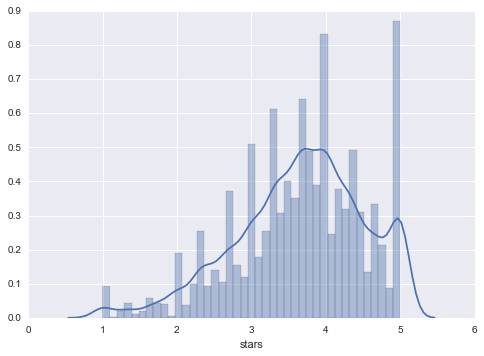

In [52]:
# All the stars ratings, means
sns.distplot(biz['stars'].aggregate(np.mean))

## Grouping by Reviewers

In [12]:
revs = df.groupby("user_id")

In [14]:
len(revs)

45981

In [15]:
rev_summary = revs.agg({'date': len, 'stars': [np.median, np.mean, np.std]})

In [17]:
rev_summary.sort_values([('date','len')], ascending=False).head()

date  stars                    
                        len median      mean       std
user_id                                               
fczQCSmaWF78toLEmb0Zsw  588    4.0  3.930272  0.791932
90a6z--_CUrl84aCzZyPsg  506    4.0  3.944664  0.784062
0CMz8YaO3f8xu4KqQgKb9Q  473    4.0  4.002114  0.714555
4ozupHULqGyO42s3zNUzOQ  442    4.0  4.260181  0.654791
joIzw_aUiNvBTuGoytrH7g  392    3.0  3.135204  0.985618

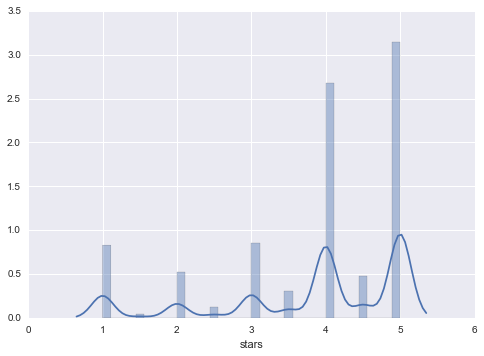

In [21]:
sns.distplot(revs['stars'].aggregate(np.median))

In [23]:
revs.size().sort_values(ascending=False).head()

user_id
fczQCSmaWF78toLEmb0Zsw    588
90a6z--_CUrl84aCzZyPsg    506
0CMz8YaO3f8xu4KqQgKb9Q    473
4ozupHULqGyO42s3zNUzOQ    442
joIzw_aUiNvBTuGoytrH7g    392
dtype: int64

In [24]:
# multiple reviewers - good, there are a lot
multiples = revs['user_id'].filter(lambda x: len(x) > 2)

In [25]:
len(multiples)

192214

## Are There Review Trends Over Time?

In [70]:
one_business = df.query('business_id == "VVeogjZya58oiTxK7qUjAQ"')

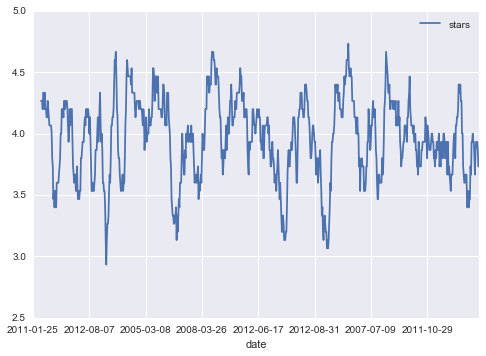

In [73]:
one_business.rolling(window=15).mean().plot('date', 'stars')

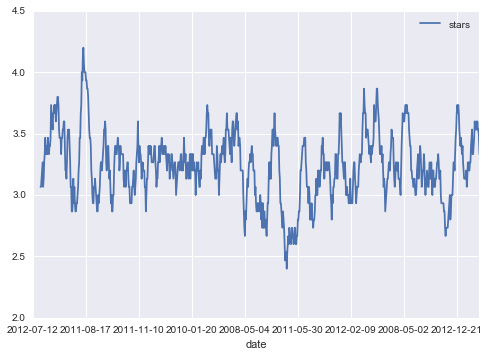

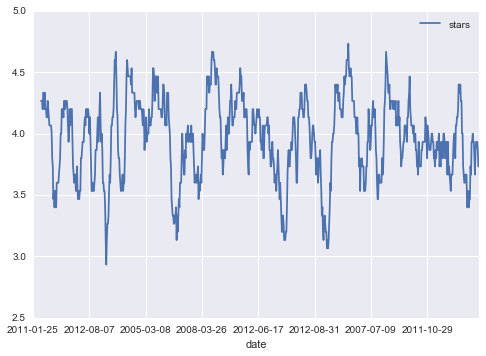

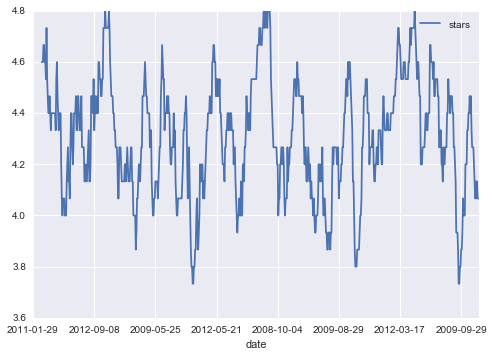

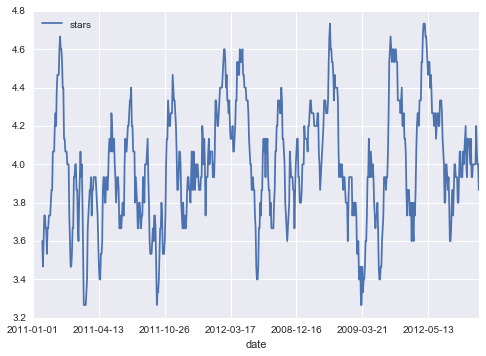

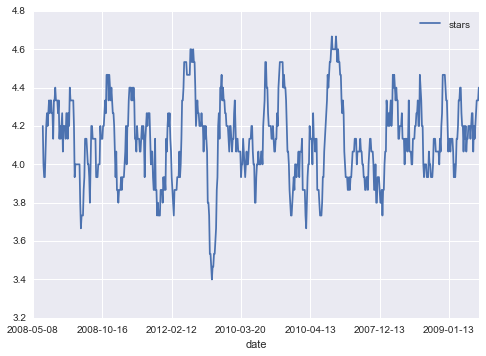

In [67]:
# show reviews over time
topmost = biz_summary.sort_values([('date','len')], ascending=False).head(n=5).index
for bizid in topmost:
    subset = df.query('business_id == "' + str(bizid) + '"')
    subset.rolling(window=15).mean().plot('date', 'stars')

## Might be useful to subset them...

In [43]:
bad = df[df.stars < 3]
good = df[df.stars > 3]

In [42]:
len(bad)

38473

In [44]:
len(good)

156071

## Do Some Text Analysis Now

In [75]:
import nltk
from nltk.corpus import stopwords
english_stops = stopwords.words('english')

## What are the most common words in this corpus?

Using nltk's Text collection functions, we can report... (or you can do by 'hand' with a counter.)

In [77]:
def tokenize(string):
    stoplist = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(string)
    return clean_tokens(tokens, stoplist)

In [78]:
def clean_tokens(tokens, stoplist):
    # Get rid of short words, stop words, punct, apostrophe-containers, and numeric strings
    import re
    import string
    """ Lowercases, takes out punct and stopwords and short strings """
    return [token.lower() for token in tokens if (token not in string.punctuation) and 
                (token.lower() not in stoplist) and 
                len(token) > 2 and re.search('[a-zA-Z]', token) and not re.search("'", token)]

In [92]:
for row,vals in df.iterrows():
    df.set_value(row, 'tokens', ' '.join(tokenize(vals['text'])))

In [94]:
# Save that out since it took so long:
df.to_msgpack('data/yelp_df_tokens.msg')

In [95]:
df = pd.read_msgpack('data/yelp_df_tokens.msg')

In [97]:
df.head(5)

,business_id,date,review_id,stars,text,user_id,tokens
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,rLtl8ZkDX5vH5nAx9C3q5Q,wife took birthday breakfast excellent weather...
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,0a2KyEL0d3Yb1V6aivbIuQ,idea people give bad reviews place goes show p...
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,0hT2KtfLiobPvh6cDC8JQg,love gyro plate rice good also dig candy selec...
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",uZetl9T0NcROGOyFfughhg,rosie dakota love chaparral dog park convenien...
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,vYmM4KTsC8ZfQBg-j5MWkw,general manager scott petello good egg detail ...


## Most common words in the whole dataset of clean tokens?

In [122]:
# item for sublist in l for item in sublist
allclean = [token for token in df.tokens.values for token in tokens.split(' ')]

In [123]:
len(allclean)

17243025

In [124]:
from nltk import Text
cleantext = Text(allclean)

In [125]:
mostcommon = cleantext.vocab().most_common()[0:1500]
mostcommon_words = [word[0] for word in mostcommon]

In [127]:
mostcommon_words[0:15]

[u'excellent',
 u'best',
 u'get',
 u'amazing',
 u'quickly',
 u'pretty',
 u'ever',
 u'made',
 u'griddled',
 u'anyway',
 u'bloody',
 u'weather',
 u'simply',
 u'looks',
 u'delicious']

In [130]:
df[0:4]['text']

0    My wife took me here on my birthday for breakf...
1    I have no idea why some people give bad review...
2    love the gyro plate. Rice is so good and I als...
3    Rosie, Dakota, and I LOVE Chaparral Dog Park!!...
Name: text, dtype: object

In [131]:
def word_count(row):
    # doesn't strip stops but ok if it applies to all
    return len(row['tokens'])

In [132]:
df['text_length'] = df.apply(lambda row: word_count(row),axis=1)

In [136]:
df.sort_values('text_length', ascending=False).head()

,business_id,date,review_id,stars,text,user_id,tokens,text_length
63676,XTtNevBI5G5x_GjFqSBMpA,2012-11-20,4ij2LU0iZ4dJDXk8fnFtEQ,2,Like J.B. - I'll keep it simple and to the poi...,Id-8-NMEKxeXBR44eUdDeA,like j.b. keep simple point least try said try...,3603
141338,1M4oczf2lmkdgbrJ3J7OqA,2012-08-18,gqHC4DfRl_LE-9SDUwqijQ,5,"Full review blogged, high points here.\n\nThe ...",5lq4LkrviYgQ4LJNsBYHcA,full review blogged high points space heard co...,3530
50817,gFJtzwGmDTABRwL2F8GsSw,2012-11-06,YOCJYcjAj33y11K_ucHjKQ,4,Comp disclosure: Generally not one to visit c...,5lq4LkrviYgQ4LJNsBYHcA,comp disclosure generally one visit chains eve...,3513
86251,Gy7ERh2GhmAYMZMO48ztBg,2010-02-18,mzif_3SuuGMyKHxiEY5ncQ,4,"Back in the day, resorts and hotels were some ...",lPaYMDmJbAnv_3pmZH_inw,back day resorts hotels best culinary destinat...,3481
36257,8m08a9xJKmANwmeuR-0bPA,2012-10-01,x2-_KKM8qu54Yjj7GIRqtQ,4,Full review blogged:\n\nTrio of Duck Fat Fries...,5lq4LkrviYgQ4LJNsBYHcA,full review blogged trio duck fat fries includ...,3446


In [134]:
print df.query('review_id == "M7vzqBAS0RoF3MdO-5SvHA"')['text'].values[0]

(aka. SKETCHY TEMPE with BONNIE G, Part Three of Three)

SET-UP: Bonnie G and Mr K walk up to the Palo Verde Lounge, a tiny run-down box nestled in the armpit of Broadway, gleaming in the diviest of glories. The outside light may as well have been flickering (but it wasn't). 

BONNIE G:  "So, Mr K, what do you think? Isn't it all you ever dreamed about? You know it is." 

ACTION: Mr K stands there for a second and takes in the aura. It is what he always dreamed about. 

MR: "Hell yeah. Let's do it." 

ACTION: Bonnie G smiles. They walk in.

SCENE: Small place. Like a shoebox. A very divey shoebox which may have seen better days. Or perhaps each of its days has always been this way. Pool table to the left. Bar to the right. Graffiti this way and that. Some palpable decrepitation. Behind the bar, a microwave. Stale scent of lingering smoke of many years still permeates. Faint scent of other odors, too. Some hipsters milling about, doing whatever it is hipsters do. Others of a more miscre

In [135]:
print df.query('review_id == "XGKwd36kg4_mt5XoJI0L_Q"')['text'].values[0]

I'm not a fan of strange phenomenons. Whether its $5 cupcakes, 25 Random Things About Me, or re-imagined frozen yogurt.

BACKGROUND
----------------------
I bought way too many vegetables at the Wednesday night farmers market downtown. And I was determined to eat them all. Did you know that boiled beets suck? They make your whole damn place smell like feet. No one told me this. 

Anyway, 2 full days of eating nothing but healthy produce. Which is supposed to make one feel alive and organic and fibrous and whatever else. But it made me downright irate. And glum. And after my 10th bowl of salad, I had more than enough of a good thing. 

I needed junk. Immediately.

Enter MoJo at the Biltmore, as I recall a friend who recently said, "Have you been to MoJo? It's awesome!!" And it happened to be open late on Friday night (till 11pm) and was just minutes away. Perfect.

But I obviously hadn't been to the Biltmore in a while because I had no idea where Mojo was. I parked by the Borders and wa

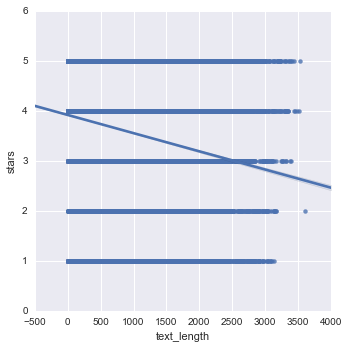

In [137]:
# some evidence longer = worse review?  Doesn't match conclusions on the following more detailed data though.
sns.lmplot(data=df, x='text_length', y='stars')

In [138]:
# a fast way to save a big df --to msgpack
df.to_msgpack("data/yelp_df_tokens_length.msg")

In [141]:
# load it
df = pd.read_msgpack("data/yelp_df_tokens_length.msg")

## Let's do some simple dictionary-based sentiment

In [143]:
# Simple sentiment analysis
from collections import defaultdict
sentiment = defaultdict(int)
with open('AFINN-111.txt') as handle:
    for line in handle.readlines():
        word = line.split('\t')[0]
        polarity = line.split('\t')[1]
        sentiment[word] = int(polarity)

In [144]:
sentiment['pho']

0

In [145]:
sentiment['great']

3

In [146]:
sentiment['awful']

-3

In [147]:
def get_net_sentiment(string):
    tokens = string.split(' ')
    total = 0
    for word in tokens:
        total += sentiment[word]
    return total

In [148]:
get_net_sentiment("the pizza is terrible")

-3

In [149]:
for row,vals in df.iterrows():
    df.set_value(row, 'net_sentiment', get_net_sentiment(vals['tokens']))

In [150]:
df.head()

,business_id,date,review_id,stars,text,user_id,tokens,text_length,net_sentiment
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,rLtl8ZkDX5vH5nAx9C3q5Q,wife took birthday breakfast excellent weather...,542,35.0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,0a2KyEL0d3Yb1V6aivbIuQ,idea people give bad reviews place goes show p...,703,22.0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,0hT2KtfLiobPvh6cDC8JQg,love gyro plate rice good also dig candy selec...,50,6.0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",uZetl9T0NcROGOyFfughhg,rosie dakota love chaparral dog park convenien...,280,10.0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,vYmM4KTsC8ZfQBg-j5MWkw,general manager scott petello good egg detail ...,248,13.0


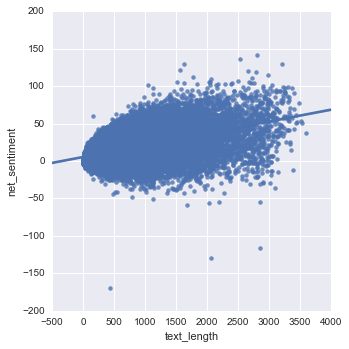

In [151]:
sns.lmplot(data=df, x='text_length', y='net_sentiment')

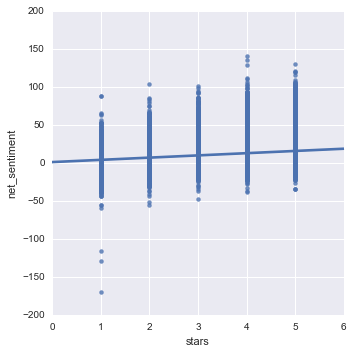

In [76]:
# Weak positive relation between stars and net_sentiment, IMO
sns.lmplot(data=df, x='stars', y='net_sentiment')

In [152]:
df['sent_per_token'] = df.net_sentiment/df.text_length

In [140]:
df.describe()

,stars,net_sentiment,text_length,sent_per_token
count,229875.000000,229875.000000,229875.000000,229875.000000
mean,3.766808,12.055896,426.355998,0.039002
std,1.216994,11.453223,372.945316,0.042616
min,1.000000,-170.000000,3.000000,-1.333333
25%,3.000000,5.000000,175.000000,0.015974
50%,4.000000,10.000000,324.000000,0.032407
75%,5.000000,17.000000,558.000000,0.053571
max,5.000000,141.000000,3603.000000,1.333333


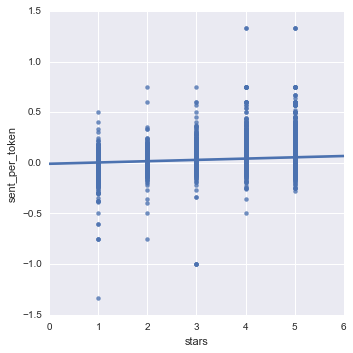

In [142]:
sns.lmplot(data=df, x='stars', y='sent_per_token')

In [153]:
# a fast way to save a big df --to msgpack
df.to_msgpack("data/yelp_df_tokens_sentiment.msg")

In [ ]:
df = pd.read_msgpack("data/yelp_df_tokens_sentiment.msg")

## Prep for Search

In [154]:
df.describe()

/Users/lynn/miniconda/envs/esnlp/lib/python2.7/site-packages/numpy/lib/function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,stars,text_length,net_sentiment,sent_per_token
count,229907.000000,229907.000000,229907.000000,229875.000000
mean,3.766723,426.296655,12.054218,0.039002
std,1.217010,372.953278,11.453309,0.042616
min,1.000000,0.000000,-170.000000,-1.333333
25%,3.000000,175.000000,5.000000,NaN
50%,4.000000,324.000000,10.000000,NaN
75%,5.000000,558.000000,17.000000,NaN
max,5.000000,3603.000000,141.000000,1.333333


In [157]:
# You could filter these out.  But be aware of what you are losing (the A+ and the "go")
df.query('text_length == 0')

,business_id,date,review_id,stars,text,user_id,tokens,text_length,net_sentiment,sent_per_token
4851,kYkuqU9wJS01L8q4d2nTTg,2010-09-08,RNow4E11pxrE3Davw9Gynw,1,Just don't.,f3LA83yEEBMj9q92H28O7w,,0,0.0,NaN
6450,tbRu-3NR5za1SEZkszcp5Q,2012-01-03,IVoMGfn9QrZ4dATwc9HBcg,3,X,SHcX9hp5RG3-OqsbvissIQ,,0,0.0,NaN
6708,KGX7O-_WqOIy9o7u9NOa9A,2011-04-19,EdFx6mNJDfJWP6yDO42cUQ,4,Go,vnSz2VT6s-gdRBjlFDACYg,,0,0.0,NaN
22740,B8ujMtvvpHyEQ2r_QlAT2w,2008-05-06,PY-Eir6BUMMfw1u0_OipiA,4,,il6RQX17f_Qxs-pssa5zMg,,0,0.0,NaN
41989,FeI75xIG8PF_XZ6P80gLBQ,2009-04-13,v-eOjkSTppvRxlB00LJAqg,3,eh...,oC0kwGvgaAeT3ZIxdxTcJA,,0,0.0,NaN
43522,nZBAnK1rOmV7bLVVDPJs0A,2011-02-26,X7aXNuBFUKvx2O3kLM4hfA,3,eh it's chili's..,3Zi1udoY2iT9s8Q3X6tgZQ,,0,0.0,NaN
54130,I6yAKGBDclGh7UlvOfqV1A,2011-12-11,TZjjbt_bskQLDnSSF7uKFg,5,A+,9VmTOyq01oIUk5zuxOj1GA,,0,0.0,NaN
69503,LfKPiwth-lGmCKTxlDoV9g,2008-05-06,NOhzie7YJMprviyeaEh_AQ,3,,il6RQX17f_Qxs-pssa5zMg,,0,0.0,NaN
72493,tbrFsCEUuq2S5lraOln4nQ,2012-08-13,rpm84EXAPoSbHEcD_JZYNA,3,Its ok.,PXUZAP_Y7YgXrDNKRpOLwA,,0,0.0,NaN
74314,ZPkomfeRH2pflacWf7U3-A,2012-11-23,lbCGla9eVmJ0JEeLiUkrHg,5,A,qDBaslzhTlpzOPg7hARuzA,,0,0.0,NaN


In [158]:
# Delete the rows with 0 text length, yes, this removes the ones with some text in it that doesn't tokenize :(
dfes = df[df.text_length != 0]

len(dfes)

229875

In [159]:
# cut text off at 558 (75%ile) for the index
dfes = df[df.text_length <= 558]

In [160]:
len(dfes)

172474

In [161]:
dfes.to_msgpack("data/yelp_filtered_length.msg")

## Work on Business Index Now...

In [162]:
biz = dfes.groupby("business_id")
# count of the dates
biz_summary = biz.agg({'date': len, 'stars': [np.median, np.mean, np.std], 'text_length': np.median, 'net_sentiment': np.median, 'sent_per_token': np.median})
biz_summary.sort_values([('date','len')], ascending=False)

date sent_per_token net_sentiment  stars            \
                        len         median        median median      mean   
business_id                                                                 
hW0Ne_HTHEAgGF1rAdmR-g  693       0.015385           3.0    3.0  3.279942   
JokKtdXU7zXHcr20Lrk29A  571       0.052419          11.0    4.0  4.352014   
VVeogjZya58oiTxK7qUjAQ  486       0.034909           9.0    4.0  3.952675   
ntN85eu27C04nwyPa8IHtw  471       0.038462           9.0    4.0  4.023355   
EWMwV5V9BxNs_U6nNVMeqw  458       0.046729          11.0    4.0  4.157205   
SDwYQ6eSu1htn8vHWv128g  439       0.050269          12.0    5.0  4.555809   
V1nEpIRmEa1768oj_tuxeQ  438       0.049184          11.0    5.0  4.399543   
WNy1uzcmm_UHmTyR--o5IA  433       0.040254          10.0    5.0  4.408776   
QnAzW6KMSciUcuJ20oI3Bw  394       0.047080          11.0    4.0  4.258883   
OFBJtqWGSx6n6CchtVmoRw  384       0.046154          10.0    4.0  3.921875   
-sC66z4SO3tR7nFCjfQwuQ  357       0.045455          10.0    4.0  4.226891   
c1yGkETheht_1vjda7G5sA  350       0.039239          10.0    5.0  4.380000   
aRkYtXfmEKYG-eTDf_qUsw  349       0.040000          10.0    5.0  4.257880   
pwpl-rxwNRQdgqFz_-qMPg  339       0.048387          11.0    4.0  4.280236   
3oZcTGb_oDHGwZFiP-7kxQ  327       0.049281          11.0    4.0  4.012232   
K8pM6qQdYu5h6buRE1-_sw  326       0.039106           9.0    5.0  4.319018   
Zx8_4zKdDBSO3qGrkukBIA  316       0.030632           7.0    4.0  4.034810   
R8VwdLyvsp9iybNqRvm94g  307       0.041667           9.0    4.0  4.094463   
_FXql6eVhbM923RdCi94SA  304       0.053964          13.0    4.0  4.115132   
3n9mSKySEv3G03YjcU-YOQ  297       0.050109          11.0    5.0  4.380471   
qjmCVYkwP-HDa35jwYucbQ  291       0.047244          11.0    4.0  3.982818   
YKOvlBNkF4KpUP9q7x862w  290       0.050898          12.0    4.0  4.158621   
5VMajxduxfLPSyQkVFKESg  279       0.044728          10.0    4.0  4.057348   
uKSX1n1RoAzGq4bV8GPHVg  278       0.041877          11.0    4.0  4.093525   
L9UYbtAUOcfTgZFimehlXw  275       0.046154          10.0    5.0  4.385455   
AqbgC7Gul5Es1rRzGNLDFA  274       0.034822           8.0    4.0  3.543796   
xY1sPHTA2RGVFlh5tZhs9g  262       0.045014          10.0    4.0  3.778626   
uEJQSIjWui-TDWXaGlcqyQ  258       0.038529          10.0    4.0  4.019380   
rZbHg4ACfN3iShdsT47WKQ  255       0.048387          12.0    5.0  4.419608   
53YGfwmbW73JhFiemNeyzQ  251       0.049618          13.0    4.0  3.924303   
...                     ...            ...           ...    ...       ...   
bNGR0iQTx8hXRmQv4hV5gw    1       0.037594          10.0    4.0  4.000000   
GE0_TCcCbviNBQhtbNOcfg    1       0.058140          20.0    5.0  5.000000   
ATk3ShTVfXD35kfMELPH7Q    1       0.049383          24.0    5.0  5.000000   
OnRGW_PdhrO95s8-I7QL4g    1       0.000000           0.0    5.0  5.000000   
pvJuii1d2CTQd9BF3gT_Sg    1       0.131148           8.0    5.0  5.000000   
pvukd8Pn1lNbzezXmGyx-Q    1       0.026829          11.0    5.0  5.000000   
6ZLsBqO2cHECURCK8LeFsQ    1       0.051402          11.0    4.0  4.000000   
mvGW6YW6LNULvdASs8IUCQ    1       0.011261           5.0    4.0  4.000000   
37TCTrXk2kFZ07hSSd5PHQ    1      -0.032520          -8.0    1.0  1.000000   
y09589YKY953yYzK4JxcRg    1       0.003846           1.0    1.0  1.000000   
KqYY2rwD8ymjU9mVJwiuRQ    1       0.263158           5.0    5.0  5.000000   
ERgRiC6UDxwSHSynlvmJtQ    1       0.012945           4.0    3.0  3.000000   
vJOzlJdQjNT4YIh3KriqsA    1       0.000000           0.0    1.0  1.000000   
KtsxJfAcDoNjhmTZeZtFmw    1       0.022951           7.0    3.0  3.000000   
OhPg5mP2v6CseLpIw7FlGg    1      -0.001980          -1.0    1.0  1.000000   
bLbZRs9Kcy1aXsdRWYJIgg    1      -0.012422          -4.0    1.0  1.000000   
XLm6u1RZ7540tiFmOAoH4g    1       0.068182          15.0    5.0  5.000000   
KwWKimlUB64oJBtYJF7Bow    1       0.017857           7.0    3.0  3.000000   
xtlgvMFsv2Xpor-Cc-t

In [163]:
# We could filter out the businesses with only 1 review, if we wanted:
biz_summary[biz_summary.loc[:, ('date', 'len')]==1].head()

date sent_per_token net_sentiment  stars           \
                        len         median        median median mean std   
business_id                                                                
-8Z6AiHwXInpnl6Q1Ey_5w    1      -0.028986          -2.0    1.0  1.0 NaN   
-CZ78c-H3tTxpP-uQ09CWw    1      -0.005970          -2.0    5.0  5.0 NaN   
-njvGjJacPJMJ9YWSr6G3Q    1       0.039286          11.0    2.0  2.0 NaN   
-nmr-3l0EmQaZAGEoXgk4w    1       0.072816          30.0    4.0  4.0 NaN   
-uSHlr8Wk6f8ewVEgsvcWQ    1       0.062112          10.0    4.0  4.0 NaN   

                       text_length  
                            median  
business_id                         
-8Z6AiHwXInpnl6Q1Ey_5w        69.0  
-CZ78c-H3tTxpP-uQ09CWw       335.0  
-njvGjJacPJMJ9YWSr6G3Q       280.0  
-nmr-3l0EmQaZAGEoXgk4w       412.0  
-uSHlr8Wk6f8ewVEgsvcWQ       161.0

In [164]:
# But let's save it with the single reviews for now
biz_summary.to_msgpack('data/biz_data.msg')

In [245]:
biz_summary = pd.read_msgpack('data/biz_data.msg')

In [246]:
biz_summary.head()

date sent_per_token net_sentiment  stars            \
                        len         median        median median      mean   
business_id                                                                 
--5jkZ3-nUPZxUvtcbr8Uw   11       0.046753          10.0    5.0  4.545455   
--BlvDO_RG2yElKu9XA1_g   29       0.041667          10.0    5.0  4.103448   
-0D_CYhlD2ILkmLR0pBmnA    3       0.023339          13.0    4.0  3.333333   
-0QBrNvhrPQCaeo7mTo0zQ    2       0.034889          14.5    4.5  4.500000   
-0bUDim5OGuv8R0Qqq6J4A    6       0.061905           4.5    2.5  2.333333   

                                 text_length  
                             std      median  
business_id                                   
--5jkZ3-nUPZxUvtcbr8Uw  0.687552       327.0  
--BlvDO_RG2yElKu9XA1_g  1.291312       242.0  
-0D_CYhlD2ILkmLR0pBmnA  1.154701       298.0  
-0QBrNvhrPQCaeo7mTo0zQ  0.707107       414.5  
-0bUDim5OGuv8R0Qqq6J4A  1.211060       104.0

## Create a Fake Name for Each Business from First Few Cap'd Words

In [165]:
def get_cap_words(text):
    # get first few cap words for a joint fake title.
    words = [word for sent in nltk.sent_tokenize(text) for word in nltk.wordpunct_tokenize(sent)\
              if word[0].isupper() and len(word) > 2]
    if len(words) >= 1:
        return ' '.join(words[0:3])
    else:
        return 'None'

In [166]:
pairs = defaultdict(dict)
for name, grouped in biz:
    #print name, len(grouped), grouped.iloc[0]
    if grouped.iloc[0].text:
        pairs[name] = get_cap_words(grouped.iloc[0].text)
    else:
        pairs[name] = "None"

In [167]:
len(pairs)

11479

In [168]:
for index, row in dfes.iterrows():
    dfes.set_value(index, 'fake_name', pairs[row.business_id])

/Users/lynn/miniconda/envs/esnlp/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/lynn/miniconda/envs/esnlp/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [247]:
dfes.head()

,business_id,date,review_id,stars,text,user_id,tokens,text_length,net_sentiment,sent_per_token,fake_name
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,rLtl8ZkDX5vH5nAx9C3q5Q,wife took birthday breakfast excellent weather...,542,35.0,0.064576,The Our Saturday
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,0hT2KtfLiobPvh6cDC8JQg,love gyro plate rice good also dig candy selec...,50,6.0,0.120000,Rice
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",uZetl9T0NcROGOyFfughhg,rosie dakota love chaparral dog park convenien...,280,10.0,0.035714,Rosie Dakota LOVE
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,vYmM4KTsC8ZfQBg-j5MWkw,general manager scott petello good egg detail ...,248,13.0,0.052419,General Manager Scott
7,hW0Ne_HTHEAgGF1rAdmR-g,2012-07-12,JL7GXJ9u4YMx7Rzs05NfiQ,4,"Luckily, I didn't have to travel far to make m...",1ieuYcKS7zeAv_U15AB13A,luckily travel far make connecting flight than...,162,13.0,0.080247,Luckily And Phoenix


In [170]:
dfes['fake_name'].head(20)

0               The Our Saturday
2                           Rice
3              Rosie Dakota LOVE
4          General Manager Scott
7            Luckily And Phoenix
8        Definitely Happy Prices
9          Nobuo Carefully Start
10              The Perhaps Here
11    Wonderful Vietnamese Their
12             They BBQ Probably
13                Good Clean Jet
15            Was Absolutely Bad
17      EVER Oakville Scottsdale
19         They Groupons Groupon
20                  DVAP You The
21                          This
22                      The ALOT
23               That They Might
24              Elsa Chicken The
25                This The Sorta
Name: fake_name, dtype: object

In [171]:
dfes.fake_name.tail(20)

229880            This Hands Fresh
229883                      Prices
229884             The However The
229886                How Well Yet
229888        Definitely Their THE
229890          Maybe Pricing This
229891             One Italian Fun
229892    This Phoenix Wonderfully
229893                  Great Hugh
229895              First The What
229896         Who Scottsdale They
229897           Nice Breads Great
229899                    This But
229900              Good Not Small
229901          Radio Milano Tried
229902               Too There The
229903        Pros Reasonable Cons
229904         The GREAT Seriously
229905                     Awesome
229906                         You
Name: fake_name, dtype: object

In [292]:
# save it
dfes.to_msgpack('data/yelp_df_forES.msg')

In [248]:
biz_summary.ix['6ozycU1RpktNG2-1BroVtw']

date            len         5.000000
sent_per_token  median      0.038961
net_sentiment   median     10.000000
stars           median      5.000000
                mean        4.600000
                std         0.894427
text_length     median    248.000000
Name: 6ozycU1RpktNG2-1BroVtw, dtype: float64

In [250]:
biz_summary['ids'] = biz_summary.index.values

In [251]:
biz_summary.head(20)

date sent_per_token net_sentiment  stars            \
                        len         median        median median      mean   
business_id                                                                 
--5jkZ3-nUPZxUvtcbr8Uw   11       0.046753          10.0    5.0  4.545455   
--BlvDO_RG2yElKu9XA1_g   29       0.041667          10.0    5.0  4.103448   
-0D_CYhlD2ILkmLR0pBmnA    3       0.023339          13.0    4.0  3.333333   
-0QBrNvhrPQCaeo7mTo0zQ    2       0.034889          14.5    4.5  4.500000   
-0bUDim5OGuv8R0Qqq6J4A    6       0.061905           4.5    2.5  2.333333   
-0xwm_AwS0d_5rwUprHGuw   10       0.061647          10.5    4.0  3.600000   
-1-sUowC7fJ-cn7mCxvJ5w    3       0.013699           3.0    1.0  2.333333   
-1N0Z3uM8xbxKS8XiAnaog    3       0.000000           0.0    2.0  2.333333   
-1bOb2izeJBZjHC7NWxiPA   42       0.036686           9.0    4.0  3.476190   
-2xCV0XGD9NxfWaVwA1-DQ    3       0.096774           9.0    5.0  4.333333   
-34jE_5dujSWMIOBudQsiQ    3       0.033520          12.0    5.0  4.666667   
-3WVw1TNQbPBzaKCaQQ1AQ  105       0.034946           8.0    4.0  3.723810   
-3xbryp44xhpN4BohxXDdQ   45       0.050633           9.0    4.0  3.644444   
-4A5xmN21zi_TXnUESauUQ  218       0.047733          11.0    5.0  4.366972   
-4QayefhaPXm6wPp-Zpb0A    3       0.081395          14.0    4.0  4.333333   
-4zMr3jk0ykmsk5sxsQMlA    3       0.038760           5.0    4.0  4.000000   
-5EWgRkudDlcCbQSIL_twA    5       0.025063          10.0    1.0  1.600000   
-5IgAihccTd8_iENVgpd9A    3       0.028926          13.0    4.0  3.333333   
-5XAZC1hC6G0NDkmPyhmUg    5       0.035417           9.0    4.0  3.600000   
-5rFC4EVrT-v8g1PSEf6Xg   30       0.052325          12.0    4.0  4.100000   

                                 text_length                     ids  
                             std      median                          
business_id                                                           
--5jkZ3-nUPZxUvtcbr8Uw  0.687552       327.0  --5jkZ3-nUPZxUvtcbr8Uw  
--BlvDO_RG2yElKu9XA1_g  1.291312       242.0  --BlvDO_RG2yElKu9XA1_g  
-0D_CYhlD2ILkmLR0pBmnA  1.154701       298.0  -0D_CYhlD2ILkmLR0pBmnA  
-0QBrNvhrPQCaeo7mTo0zQ  0.707107       414.5  -0QBrNvhrPQCaeo7mTo0zQ  
-0bUDim5OGuv8R0Qqq6J4A  1.211060       104.0  -0bUDim5OGuv8R0Qqq6J4A  
-0xwm_AwS0d_5rwUprHGuw  0.966092       174.5  -0xwm_AwS0d_5rwUprHGuw  
-1-sUowC7fJ-cn7mCxvJ5w  2.309401       219.0  -1-sUowC7fJ-cn7mCxvJ5w  
-1N0Z3uM8xbxKS8XiAnaog  1.527525       378.0  -1N0Z3uM8xbxKS8XiAnaog  
-1bOb2izeJBZjHC7NWxiPA  1.064690       232.0  -1bOb2izeJBZjHC7NWxiPA  
-2xCV0XGD9NxfWaVwA1-DQ  1.154701        56.0  -2xCV0XGD9NxfWaVwA1-DQ  
-34jE_5dujSWMIOBudQsiQ  0.577350       379.0  -34jE_5dujSWMIOBudQsiQ  
-3WVw1TNQbPBzaKCaQQ1AQ  1.023712       245.0  -3WVw1TNQbPBzaKCaQQ1AQ  
-3xbryp44xhpN4BohxXDdQ  1.227628       205.0  -3xbryp44xhpN4BohxXDdQ  
-4A5xmN21zi_TXnUESauUQ  0.865739       220.0  -4A5xmN21zi_TXnUESauUQ  
-4QayefhaPXm6wPp-Zpb0A  0.577350       171.0  -4QayefhaPXm6wPp-Zpb0A  
-4zMr3jk0ykmsk5sxsQMlA  1.000000       129.0  -4zMr3jk0ykmsk5sxsQMlA  
-5EWgRkudDlcCbQSIL_twA  1.341641       409.0  -5EWgRkudDlcCbQSIL_twA  
-5IgAihccTd8_iENVgpd9A  1.154701       305.0  -5IgAihccTd8_iENVgpd9A  
-5XAZC1hC6G0NDkmPyhmUg  0.894427       274.0  -5XAZC1hC6G0NDkmPyhmUg  
-5rFC4EVrT-v8g1PSEf6Xg  1.124952       278.0  -5rFC4EVrT-v8g1PSEf6Xg

In [253]:
ids = biz_summary.index.values

In [252]:
len(ids)
len(biz_summary)

11479

In [254]:
biz_flat = pd.DataFrame(biz_summary.to_records())

In [256]:
len(biz_flat)

11479

In [268]:
biz_flat.columns

Index([u'business_id', u'('date', 'len')', u'('sent_per_token', 'median')',
       u'('net_sentiment', 'median')', u'('stars', 'median')',
       u'('stars', 'mean')', u'('stars', 'std')', u'('text_length', 'median')',
       u'('ids', '')'],
      dtype='object')

In [287]:
cols = ['business_id', 'reviews',
 'sent_per_token_median',
 'net_sentiment_median',
 'stars_median',
 'stars_mean',
 'stars_std',
 'text_length_median',
 'ids']

In [288]:
biz_flat.columns = cols

In [289]:
biz_flat.head()

,business_id,reviews,sent_per_token_median,net_sentiment_median,stars_median,stars_mean,stars_std,text_length_median,ids,fake_name
0,--5jkZ3-nUPZxUvtcbr8Uw,11,0.046753,10.0,5.0,4.545455,0.687552,327.0,--5jkZ3-nUPZxUvtcbr8Uw,George The Tzatziki
1,--BlvDO_RG2yElKu9XA1_g,29,0.041667,10.0,5.0,4.103448,1.291312,242.0,--BlvDO_RG2yElKu9XA1_g,Hawaii Hawaii That
2,-0D_CYhlD2ILkmLR0pBmnA,3,0.023339,13.0,4.0,3.333333,1.154701,298.0,-0D_CYhlD2ILkmLR0pBmnA,Saw Olive Gourmet
3,-0QBrNvhrPQCaeo7mTo0zQ,2,0.034889,14.5,4.5,4.500000,0.707107,414.5,-0QBrNvhrPQCaeo7mTo0zQ,Best The Mexican
4,-0bUDim5OGuv8R0Qqq6J4A,6,0.061905,4.5,2.5,2.333333,1.211060,104.0,-0bUDim5OGuv8R0Qqq6J4A,This


In [280]:
len(ids)
len(biz_flat)

11479

In [281]:
for index, id in enumerate(ids):
    biz_flat.set_value(index, 'fake_name', pairs[id])

In [290]:
biz_flat.head(5)

,business_id,reviews,sent_per_token_median,net_sentiment_median,stars_median,stars_mean,stars_std,text_length_median,ids,fake_name
0,--5jkZ3-nUPZxUvtcbr8Uw,11,0.046753,10.0,5.0,4.545455,0.687552,327.0,--5jkZ3-nUPZxUvtcbr8Uw,George The Tzatziki
1,--BlvDO_RG2yElKu9XA1_g,29,0.041667,10.0,5.0,4.103448,1.291312,242.0,--BlvDO_RG2yElKu9XA1_g,Hawaii Hawaii That
2,-0D_CYhlD2ILkmLR0pBmnA,3,0.023339,13.0,4.0,3.333333,1.154701,298.0,-0D_CYhlD2ILkmLR0pBmnA,Saw Olive Gourmet
3,-0QBrNvhrPQCaeo7mTo0zQ,2,0.034889,14.5,4.5,4.500000,0.707107,414.5,-0QBrNvhrPQCaeo7mTo0zQ,Best The Mexican
4,-0bUDim5OGuv8R0Qqq6J4A,6,0.061905,4.5,2.5,2.333333,1.211060,104.0,-0bUDim5OGuv8R0Qqq6J4A,This


In [2]:
# save it
biz_flat.to_msgpack('data/biz_statsdf_for_ES.msg')

#### We can use both tables in ES for different things now.

## Topic Modeling Aside

In [22]:
""" An alternate from gensim tutorials - just use all words in the model in a rewiew. """

import re

class YelpReviews(object):
    """Iterate over sentences of all plaintext files in a directory """
    SPLIT_SENTENCES = re.compile(u"[.!?:]\s+")  # split sentences on these characters

    def __init__(self, objs, field):
        self.field = field
        self.objs = objs

    def __iter__(self):
        for obj in self.objs:
            text = obj[self.field]
            for sentence in self.SPLIT_SENTENCES.split(text):
                yield gensim.utils.simple_preprocess(sentence, deacc=True)

In [85]:
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import string

def simple_tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

#strip any cap words as proxy for proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
def tokenize_strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.wordpunct_tokenize(sent)\
              if word.islower() and len(word) > 2]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [86]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
import re

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    # also remove upper case words and stop words
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.wordpunct_tokenize(sent)\
              if word.islower() and len(word) > 2]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return "".join([" "+i if not i.startswith("'") else i for i in stems]).strip()

In [29]:
tokenize_strip_proppers(data[0]['text'])

u'wife took here birthday for breakfast and was excellent weather was perfect which made sitting outside overlooking their grounds absolute pleasure waitress was excellent and our food arrived quickly the semi busy morning looked like the place fills pretty quickly the earlier you get here the better yourself favor and get their was phenomenal and simply the best ever had pretty sure they only use ingredients from their garden and blend them fresh when you order was amazing the menu looks excellent had the white truffle scrambled eggs vegetable skillet and was tasty and delicious came with pieces their griddled bread with was amazing and absolutely made the meal complete was the best toast ever had can wait back'

In [88]:
tokenize_and_stem(data[0]['text'])

u'wife took here birthday for breakfast and was excel weather was perfect which made sit outsid overlook their ground absolut pleasur waitress was excel and our food arriv quick the semi busi morn look like the place fill pretti quick the earlier you get here the better yourself favor and get their was phenomen and simpli the best ever had pretti sure they onli use ingredi from their garden and blend them fresh when you order was amaz the menu look excel had the white truffl scrambl egg veget skillet and was tasti and delici came with piec their griddl bread with was amaz and absolut made the meal complet was the best toast ever had can wait back'

In [31]:
data[0]

{u'business_id': u'9yKzy9PApeiPPOUJEtnvkg',
 u'date': u'2011-01-26',
 u'review_id': u'fWKvX83p0-ka4JS3dc6E5A',
 u'stars': 5,
 u'text': u'My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.\n\nDo yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I\'ve ever had.  I\'m pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.\n\nWhile EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I\'ve ever had.\

In [82]:
def get_review_tokens(dataset):
    for doc in dataset:
        text = tokenize_and_stem(doc[u'text'])
        idn = doc[u'review_id']
        tokens = simple_tokenize(text)
        if len(tokens) < 10:
            continue  # ignore short articles and various meta-articles
        yield idn, tokens

In [93]:

class MyCorpus(object):
    def __init__(self, data_file, dictionary):
        """
        Parse the docs in data file.
        Yield each document in turn, as a list of tokens (unicode strings).
        
        """
        self.data_file = data_file
        self.dictionary = dictionary
    
    def __iter__(self):
        self.ids = []
        for idn, tokens in get_review_tokens(self.data_file):
            self.ids.append(idn)
            yield self.dictionary.doc2bow(tokens)
    

In [88]:
# Beware - will do stems or not depending on current def of get_review_tokens
doc_stream = (tokens for _, tokens in get_review_tokens(data)) # dep on def of the review_tokens - stems or words

In [39]:
%time id2word_yelp = gensim.corpora.Dictionary(doc_stream)
print(id2word_yelp)

CPU times: user 5min 54s, sys: 8.01 s, total: 6min 2s
Wall time: 6min 53s
Dictionary(84992 unique tokens: [u'fawn', u'remastered', u'belligerence', u'vang', u'saimin']...)


In [89]:
%time id2wordstems_yelp = gensim.corpora.Dictionary(doc_stream)
print(id2wordstems_yelp)

CPU times: user 17min 48s, sys: 15.4 s, total: 18min 4s
Wall time: 18min 4s
Dictionary(55969 unique tokens: [u'fawn', u'circuitri', u'gai', u'mustachio', u'woodi']...)


In [90]:
id2wordstems_yelp.save('data/id2wordstems_yelp_dictionary.dict')

In [41]:
# create a stream of bag-of-words vectors
review_corpus = MyCorpus(data, id2word_yelp)

In [94]:
# create a stream of bag-of-words vectors
reviewstems_corpus = MyCorpus(data, id2wordstems_yelp)

In [43]:
import itertools
vector = next(iter(review_corpus))
print(vector)  # print the first vector in the stream

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 2), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 3), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1)]


In [45]:
# what is the most common word in that first article?
most_index, most_count = max(vector, key=lambda (word_index, count): count)
print(id2word_yelp[most_index], most_count)

(u'excellent', 3)


In [46]:
%time gensim.corpora.MmCorpus.serialize('data/yelp_bow.mm', review_corpus)

CPU times: user 7min 49s, sys: 11.8 s, total: 8min
Wall time: 9min


In [95]:
%time gensim.corpora.MmCorpus.serialize('data/yelpstems_bow.mm', reviewstems_corpus)

CPU times: user 19min 40s, sys: 14.9 s, total: 19min 55s
Wall time: 20min 24s


In [47]:
mm_corpus = gensim.corpora.MmCorpus('data/yelp_bow.mm')
print(mm_corpus)

MmCorpus(208951 documents, 84992 features, 9612630 non-zero entries)


In [77]:
mmstems_corpus = gensim.corpora.MmCorpus('data/yelpstems_bow.mm')
print(mmstems_corpus)

MmCorpus(210280 documents, 55969 features, 9693003 non-zero entries)


## Create Topic Models for the Reviews -- Using Stemmed and Unstemmed

In [79]:
clipped_corpus = gensim.utils.ClippedCorpus(mm_corpus, 6000)  # use fewer documents during training, LDA is slow

%time lda_model = gensim.models.LdaModel(clipped_corpus, num_topics=15, update_every=5, id2word=id2word_yelp, passes=20)
#update_every=5, chunksize=10000

CPU times: user 8min 21s, sys: 7.67 s, total: 8min 29s
Wall time: 8min 37s


In [97]:
clipped_corpus2 = gensim.utils.ClippedCorpus(mmstems_corpus, 6000)  # use fewer documents during training, LDA is slow

%time ldastems_model = gensim.models.LdaModel(clipped_corpus2, num_topics=15, update_every=5, id2word=id2wordstems_yelp, passes=20)
#update_every=5, chunksize=10000

CPU times: user 8min 38s, sys: 6.32 s, total: 8min 44s
Wall time: 8min 53s


In [80]:
lda_model.print_topics(-1)  # print a few most important words for each LDA topic


[(0,
  u'0.006*good + 0.005*great + 0.005*place + 0.004*ordered + 0.004*food + 0.004*like + 0.003*time + 0.003*wine + 0.003*salad + 0.003*cheese'),
 (1,
  u'0.015*food + 0.013*good + 0.013*place + 0.010*time + 0.009*like + 0.009*service + 0.006*order + 0.006*got + 0.005*came + 0.005*ordered'),
 (2,
  u'0.019*good + 0.018*food + 0.010*chicken + 0.010*place + 0.010*great + 0.008*like + 0.006*cheese + 0.006*tacos + 0.006*salsa + 0.005*ordered'),
 (3,
  u'0.037*pizza + 0.009*good + 0.008*service + 0.007*crust + 0.006*great + 0.006*food + 0.005*place + 0.004*restaurant + 0.004*like + 0.004*location'),
 (4,
  u'0.003*chocolate + 0.003*cupcakes + 0.002*cupcake + 0.002*yogurt + 0.001*kids + 0.001*venue + 0.001*fabric + 0.001*cake + 0.001*backyard + 0.001*wedding'),
 (5,
  u'0.006*books + 0.004*library + 0.003*donuts + 0.002*donut + 0.001*book + 0.001*museum + 0.001*river + 0.001*gross + 0.001*read + 0.001*pets'),
 (6,
  u'0.004*place + 0.003*service + 0.003*pool + 0.003*food + 0.003*great + 0.

In [98]:
ldastems_model.print_topics(-1)  # print a few most important words for each LDA topic


[(0,
  u'0.003*lake + 0.001*gas + 0.001*like + 0.001*want + 0.001*yeah + 0.001*roll + 0.001*boat + 0.001*panang + 0.001*desert + 0.001*station'),
 (1,
  u'0.003*soap + 0.003*bus + 0.002*moistur + 0.001*lavend + 0.001*deejay + 0.001*brim + 0.001*mint + 0.001*arrang + 0.001*wax + 0.001*inclus'),
 (2,
  u'0.012*donut + 0.003*order + 0.002*pretzel + 0.002*want + 0.002*place + 0.002*good + 0.002*best + 0.002*sum + 0.002*food + 0.002*dim'),
 (3,
  u'0.085*pizza + 0.015*crust + 0.011*good + 0.009*slice + 0.009*salad + 0.007*order + 0.006*wing + 0.006*chees + 0.005*pie + 0.005*like'),
 (4,
  u'0.004*trail + 0.004*hike + 0.003*tea + 0.002*water + 0.002*grass + 0.002*hiker + 0.002*like + 0.002*backyard + 0.001*tree + 0.001*center'),
 (5,
  u'0.003*wash + 0.002*thier + 0.002*car + 0.001*map + 0.001*cow + 0.001*windshield + 0.001*model + 0.001*nephew + 0.001*blade + 0.001*dairi'),
 (6,
  u'0.021*cupcak + 0.004*frost + 0.002*great + 0.002*fro + 0.002*good + 0.002*review + 0.002*custard + 0.001*bra 

In [123]:
sample = (tokens for _, tokens in get_review_tokens(data))

In [78]:
for doc in sample:
    print doc
    print lda_model.get_document_topics(id2word_yelp.doc2bow(doc))

[u'wife', u'took', u'birthday', u'breakfast', u'excellent', u'weather', u'perfect', u'sitting', u'outside', u'overlooking', u'grounds', u'absolute', u'pleasure', u'waitress', u'excellent', u'food', u'arrived', u'quickly', u'semi', u'busy', u'morning', u'looked', u'like', u'place', u'fills', u'pretty', u'quickly', u'earlier', u'better', u'favor', u'phenomenal', u'simply', u'best', u'pretty', u'sure', u'use', u'ingredients', u'garden', u'blend', u'fresh', u'order', u'amazing', u'menu', u'looks', u'excellent', u'white', u'truffle', u'scrambled', u'eggs', u'vegetable', u'skillet', u'tasty', u'delicious', u'came', u'pieces', u'griddled', u'bread', u'amazing', u'absolutely', u'meal', u'complete', u'best', u'toast', u'wait']
[(4, 0.1118140268140206), (6, 0.52080972789300939), (11, 0.35506853596995919)]
[u'idea', u'people', u'bad', u'reviews', u'place', u'goes', u'probably', u'griping', u'fault', u'people', u'like', u'case', u'friend', u'arrived', u'past', u'pretty', u'crowded', u'thought', u'

In [100]:
for doc in sample:
    print " ".join(doc)
    print ldastems_model.get_document_topics(id2wordstems_yelp.doc2bow(doc))

wife took birthday breakfast excel weather perfect sit outsid overlook ground absolut pleasur waitress excel food arriv quick semi busi morn look like place pretti quick earlier better favor phenomen simpli best pretti sure onli use ingredi garden blend fresh order amaz menu look excel white truffl scrambl egg veget skillet tasti delici came piec griddl bread amaz absolut meal complet best toast wait
[(8, 0.12423999650546777), (10, 0.58247846428765693), (11, 0.28097383789597324)]
idea whi peopl bad review place goe pleas everyon probabl gripe someth fault mani peopl like ani case friend arriv past pretti crowd thought thought wait forev seat said seat girl come seat someon els seat waiter came got drink order veri pleasant host seat waiter server price veri good place order onc decid want share bake spaghetti calzon small pizza tri calzon huge got smallest person got small pizza awesom friend like pizza better like calzon better calzon doe sweetish sauc like sauc box pizza home door ev

In [101]:
ldastems_model.save('data/ldastems_model.mod')

In [102]:
lda_model.save('data/lda_model.mod')

In [80]:
ldastems_model = gensim.models.LdaModel.load('data/ldastems_model.mod')

In [112]:
df.head()

,business_id,date,review_id,stars,text,user_id
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,rLtl8ZkDX5vH5nAx9C3q5Q
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,0a2KyEL0d3Yb1V6aivbIuQ
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,0hT2KtfLiobPvh6cDC8JQg
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",uZetl9T0NcROGOyFfughhg
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,vYmM4KTsC8ZfQBg-j5MWkw


In [104]:
df['topics_stemmed'] = ""
for row,vals in df.iterrows():
    tokens = tokenize_and_stem(vals['text'])
    df.set_value(row, 'tokens_stemmed', tokens)
    topics = ldastems_model.get_document_topics(id2wordstems_yelp.doc2bow(tokens.split(' ')))
    topstring = ';'.join([str(w[0]) + ':' + str(w[1]) for w in topics])
    df.set_value(row, 'topics_stemmed', str(topstring))

In [97]:
topics = [(8, 0.12424965619294445), (10, 0.58240970356859401), (11, 0.28103293892798464)]

In [185]:
df.head()

,business_id,date,review_id,stars,text,user_id,tokens,net_sentiment,text_length,tokens_stemmed,topics_stemmed,sent_per_token
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,rLtl8ZkDX5vH5nAx9C3q5Q,wife took birthday breakfast excellent weather...,35.0,542,wife took here birthday for breakfast and was ...,8:0.124248119419;10:0.582431169676;11:0.281013...,0.064576
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,0a2KyEL0d3Yb1V6aivbIuQ,idea people give bad reviews place goes show p...,22.0,703,have idea whi some peopl give bad review about...,3:0.127784743918;9:0.279232475457;10:0.5850619...,0.031294
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,0hT2KtfLiobPvh6cDC8JQg,love gyro plate rice good also dig candy selec...,6.0,50,love the gyro plate good and also dig their ca...,11:0.883333204766,0.120000
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",uZetl9T0NcROGOyFfughhg,rosie dakota love chaparral dog park convenien...,10.0,280,and veri conveni and surround lot path desert ...,7:0.14959518433;9:0.434998933203;14:0.39187644...,0.035714
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,vYmM4KTsC8ZfQBg-j5MWkw,general manager scott petello good egg detail ...,13.0,248,good egg into detail but let assur you you hav...,7:0.966666626696,0.052419


## What You Could Do Next

You could use the topics to filter out topics of lesser interest, like the dog parks and salons, if you're interested in restaurants.
Beware, though, because "hot dogs" and restaurants that are pet-friendly may get folded in with dog parks.
